In [ ]:
# Import semua library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import joblib
from scipy import stats

In [ ]:
 #Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

**Upload your file:**

Click the folder icon in the left sidebar, then click the upload icon and select your file (`rumah123_yogya_clean.csv`).

In [ ]:
# Load dataset from the uploaded CSV file
df = pd.read_csv('rumah123_yogya_clean.csv')
display(df.head())

,price,nav-link,description,listing-location,bed,bath,carport,surface_area,building_area,price_per_m2,kecamatan,kabupaten,loc_encoded
0,1.790000e+09,https://www.rumah123.com/properti/sleman/hos17...,Rumah 2 Lantai Baru di jalan Palagan Sleman Y...,"Ngaglik, Sleman",3.0,3.0,2.0,120.0,110.0,1.627273e+07,Ngaglik,Sleman,36
1,1.700000e+08,https://www.rumah123.com/properti/sleman/hos17...,RUMAH BARU DEKAT AL AZHAR DAN UGM,"Jombor, Sleman",3.0,2.0,1.0,102.0,126.0,1.349206e+06,Jombor,Sleman,22
2,6.950000e+08,https://www.rumah123.com/properti/sleman/hos17...,RUMAH ASRI DAN SEJUK DI BERBAH SLEMAN DEKAT PA...,"Berbah, Sleman",2.0,2.0,1.0,100.0,100.0,6.950000e+06,Berbah,Sleman,4
3,5.600000e+08,https://www.rumah123.com/properti/sleman/hos17...,Rumah Murah 5 Menit Dari Candi Prambanan Tersi...,"Prambanan, Sleman",3.0,1.0,1.0,109.0,67.0,8.358209e+06,Prambanan,Sleman,46
4,2.000000e+08,https://www.rumah123.com/properti/sleman/hos17...,Rumah Murah Cicilan 1jt Di Moyudan Sleman,"Moyudan, Sleman",2.0,1.0,1.0,60.0,30.0,6.666667e+06,Moyudan,Sleman,35


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             1587 non-null   float64
 1   nav-link          1587 non-null   object 
 2   description       1587 non-null   object 
 3   listing-location  1587 non-null   object 
 4   bed               1587 non-null   float64
 5   bath              1587 non-null   float64
 6   carport           1587 non-null   float64
 7   surface_area      1587 non-null   float64
 8   building_area     1587 non-null   float64
 9   price_per_m2      1587 non-null   float64
 10  kecamatan         1587 non-null   object 
 11  kabupaten         1587 non-null   object 
 12  loc_encoded       1587 non-null   int64  
dtypes: float64(7), int64(1), object(5)
memory usage: 161.3+ KB


In [ ]:
df.isnull().sum()

,0
price,0
nav-link,0
description,0
listing-location,0
bed,0
bath,0
carport,0
surface_area,0
building_area,0
price_per_m2,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:

# #5 Fungsi untuk membersihkan kolom harga
def clean_and_convert_price(price):
    """
    Membersihkan dan mengkonversi format harga Indonesia ke numeric
    """
    if pd.isna(price):
        return np.nan

    price = str(price)
    # Ganti koma dengan titik untuk decimal
    price = re.sub(r',', '.', price)
    # Hapus prefix "Rp"
    price = re.sub(r'Rp\s?', '', price)

    try:
        if "Miliar" in price or "miliar" in price:
            price = re.sub(r'\s*(M|m)iliar', '', price)
            return float(price) * 1_000_000_000
        elif "Juta" in price or "juta" in price:
            price = re.sub(r'\s*(J|j)uta', '', price)
            return float(price) * 1_000_000
        else:
            # Jika sudah dalam bentuk angka
            return float(price)
    except ValueError:
        return np.nan


In [ ]:
# #6 Apply cleaning pada kolom price
print("Membersihkan kolom harga...")
df["price"] = df["price"].apply(clean_and_convert_price)

# #7 Extract lokasi dari listing-location
print("Memproses kolom lokasi...")
df['location'] = df['listing-location'].apply(lambda x: str(x).split(',')[-1].strip() if pd.notna(x) else np.nan)

Membersihkan kolom harga...
Memproses kolom lokasi...


In [ ]:
 #7 Membersihkan kolom surface_area dan building_area
print("Membersihkan kolom luas tanah dan bangunan...")
df['surface_area'] = df['surface_area'].apply(lambda x: float(str(x).split()[0]) if pd.notna(x) and str(x).split()[0].replace('.','').isdigit() else np.nan)
df['building_area'] = df['building_area'].apply(lambda x: float(str(x).split()[0]) if pd.notna(x) and str(x).split()[0].replace('.','').isdigit() else np.nan)


Membersihkan kolom luas tanah dan bangunan...


In [ ]:
#8 Drop kolom yang tidak diperlukan
columns_to_drop = ['nav-link', 'description', 'listing-location']
existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_cols_to_drop, inplace=True)
print(f"Kolom yang dihapus: {existing_cols_to_drop}")

Kolom yang dihapus: ['nav-link', 'description', 'listing-location']


In [ ]:
#9 Convert data types ke format yang sesuai
print("Mengkonversi tipe data...")
df['price'] = df['price'].astype('int64')
df['bed'] = df['bed'].astype('int64')
df['bath'] = df['bath'].astype('int64')
df['carport'] = df['carport'].astype('int64')
df['building_area'] = df['building_area'].astype('float64')
df['surface_area'] = df['surface_area'].astype('float64')
df['location'] = df['location'].str.strip()

Mengkonversi tipe data...


In [ ]:
 #10 Rename kolom untuk clarity
df.rename(columns={
    'building_area': 'building_area_m2',
    'surface_area': 'surface_area_m2'
}, inplace=True)

print("✅ Data preprocessing selesai!")
print(f"Final dataset shape: {df.shape}")

✅ Data preprocessing selesai!
Final dataset shape: (1587, 11)


In [ ]:
#11 Tampilkan dataset yang sudah bersih
print("\nDataset setelah preprocessing:")
display(df.head())


Dataset setelah preprocessing:


,price,bed,bath,carport,surface_area_m2,building_area_m2,price_per_m2,kecamatan,kabupaten,loc_encoded,location
0,1790000000,3,3,2,120.0,110.0,1.627273e+07,Ngaglik,Sleman,36,Sleman
1,170000000,3,2,1,102.0,126.0,1.349206e+06,Jombor,Sleman,22,Sleman
2,695000000,2,2,1,100.0,100.0,6.950000e+06,Berbah,Sleman,4,Sleman
3,560000000,3,1,1,109.0,67.0,8.358209e+06,Prambanan,Sleman,46,Sleman
4,200000000,2,1,1,60.0,30.0,6.666667e+06,Moyudan,Sleman,35,Sleman


**EXPLORATORY DATA ANALYSIS**

In [ ]:
df.describe()

,price,bed,bath,carport,surface_area_m2,building_area_m2,price_per_m2,loc_encoded
count,1.587000e+03,1587.000000,1587.000000,1587.000000,1587.000000,1.587000e+03,1.587000e+03,1587.000000
mean,1.231515e+09,3.456207,2.521739,1.372401,136.935728,1.517536e+06,1.146019e+07,29.230624
std,8.612359e+08,2.420190,2.454119,0.795998,113.527959,6.044983e+07,4.680594e+06,16.780040
min,7.000000e+06,1.000000,1.000000,1.000000,36.000000,4.000000e+00,9.966157e-01,0.000000
25%,5.920000e+08,2.000000,1.000000,1.000000,92.000000,5.750000e+01,8.651515e+06,13.000000
50%,8.800000e+08,3.000000,2.000000,1.000000,111.000000,8.500000e+01,1.069231e+07,31.000000
75%,1.785000e+09,4.000000,3.000000,2.000000,145.000000,1.350000e+02,1.331667e+07,37.000000
max,4.000000e+09,40.000000,42.000000,11.000000,2769.000000,2.408150e+09,7.250000e+07,63.000000


Text(0.5, 0, 'Jumlah Properti')

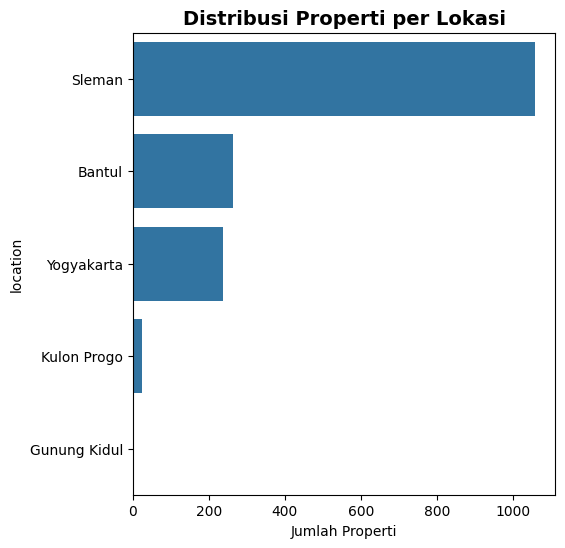

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
location_counts = df['location'].value_counts()
sns.countplot(data=df, y='location', order=location_counts.index)
plt.title('Distribusi Properti per Lokasi', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Properti')

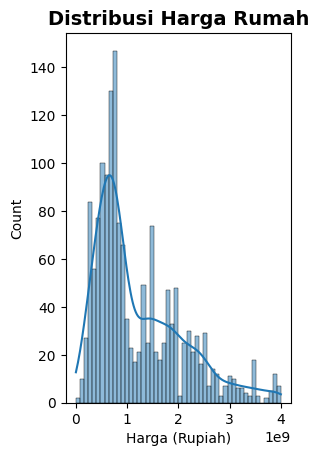

In [ ]:
#12 Distribusi harga
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='price', bins=50, kde=True)
plt.title('Distribusi Harga Rumah', fontsize=14, fontweight='bold')
plt.xlabel('Harga (Rupiah)')
plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))


<Figure size 1500x1000 with 0 Axes>

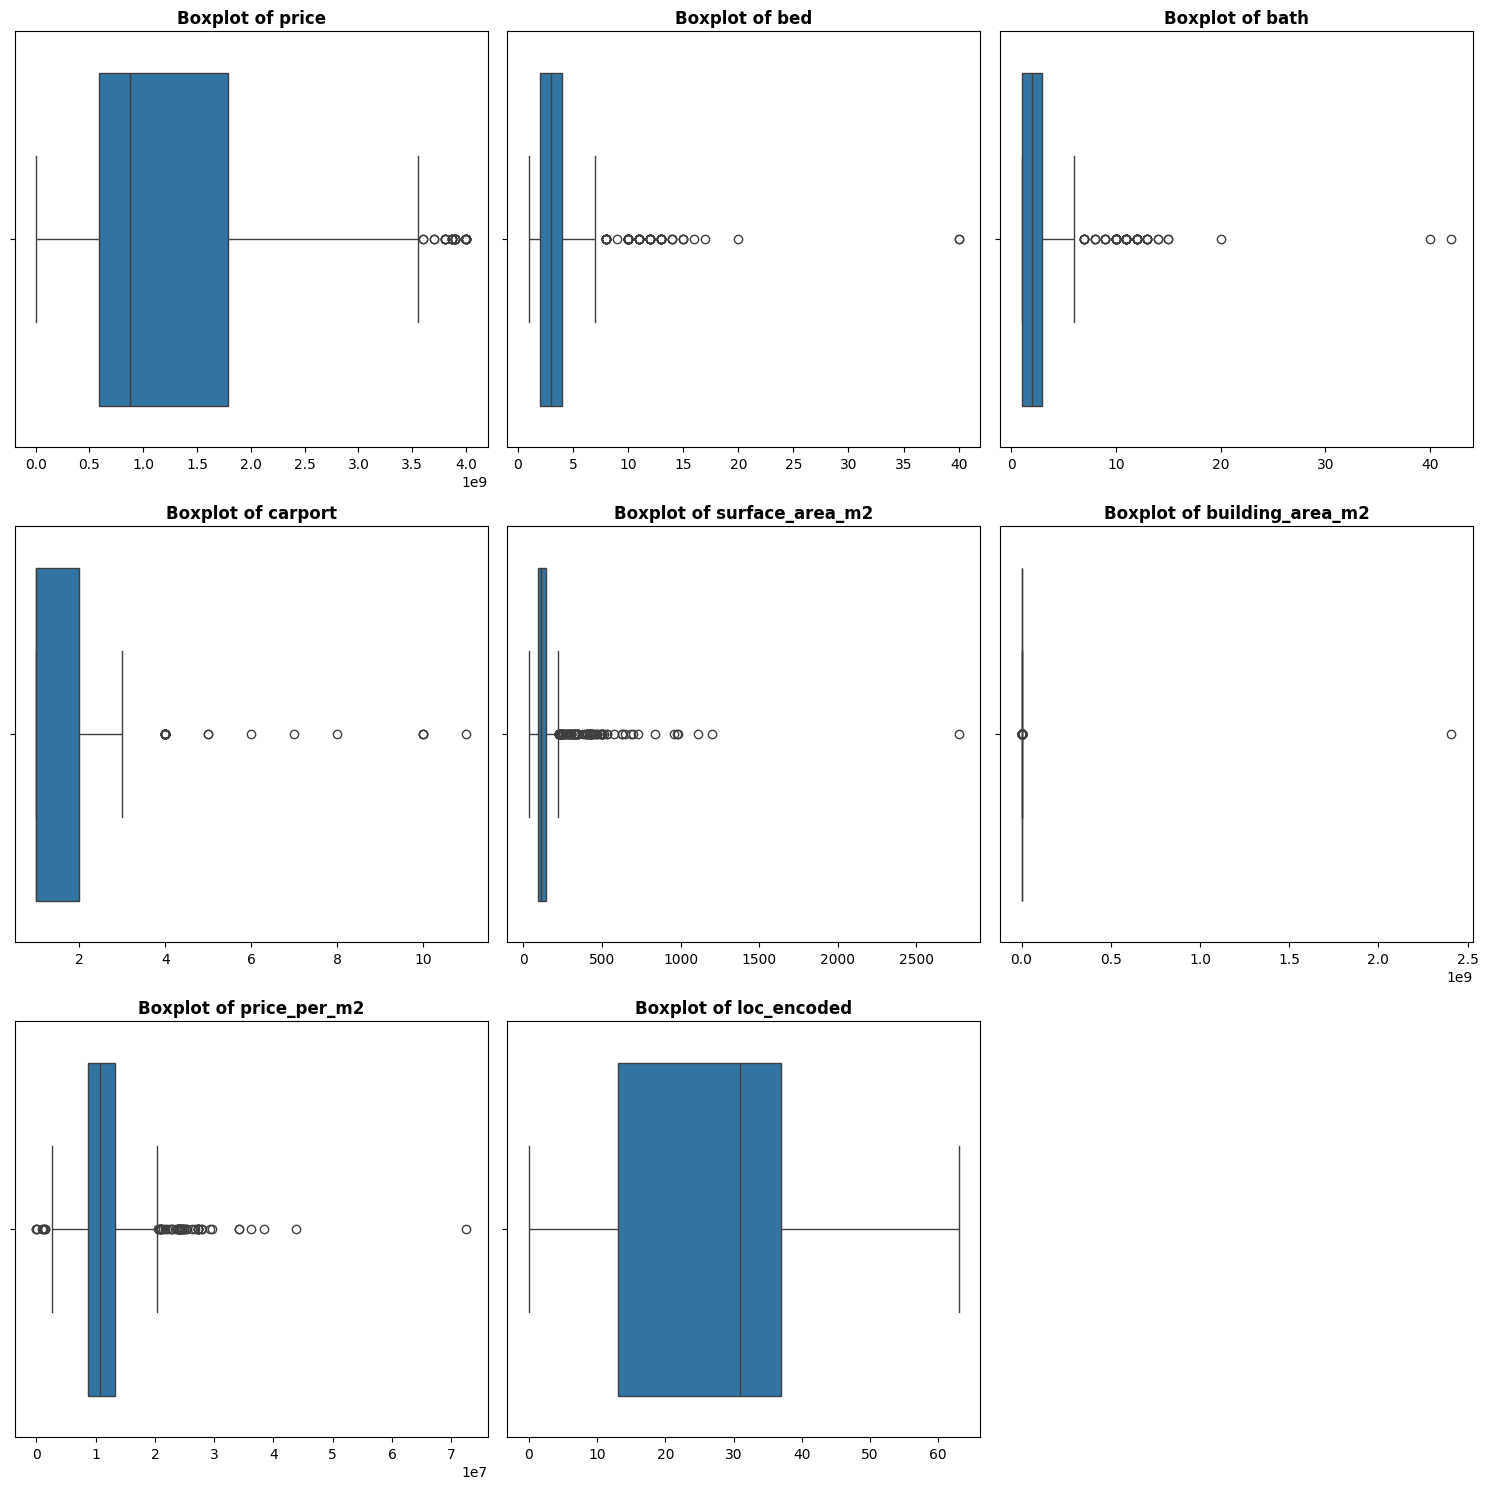

In [ ]:
#13 Boxplot untuk deteksi outliers (per atribut)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(15, 10))

# Calculate the number of rows needed based on the number of numeric columns and columns per row
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5)) # Adjust figure size based on number of rows

for i, col in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}', fontweight='bold')
    plt.xlabel("")
    plt.ylabel("")

    if col == 'price':
        plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

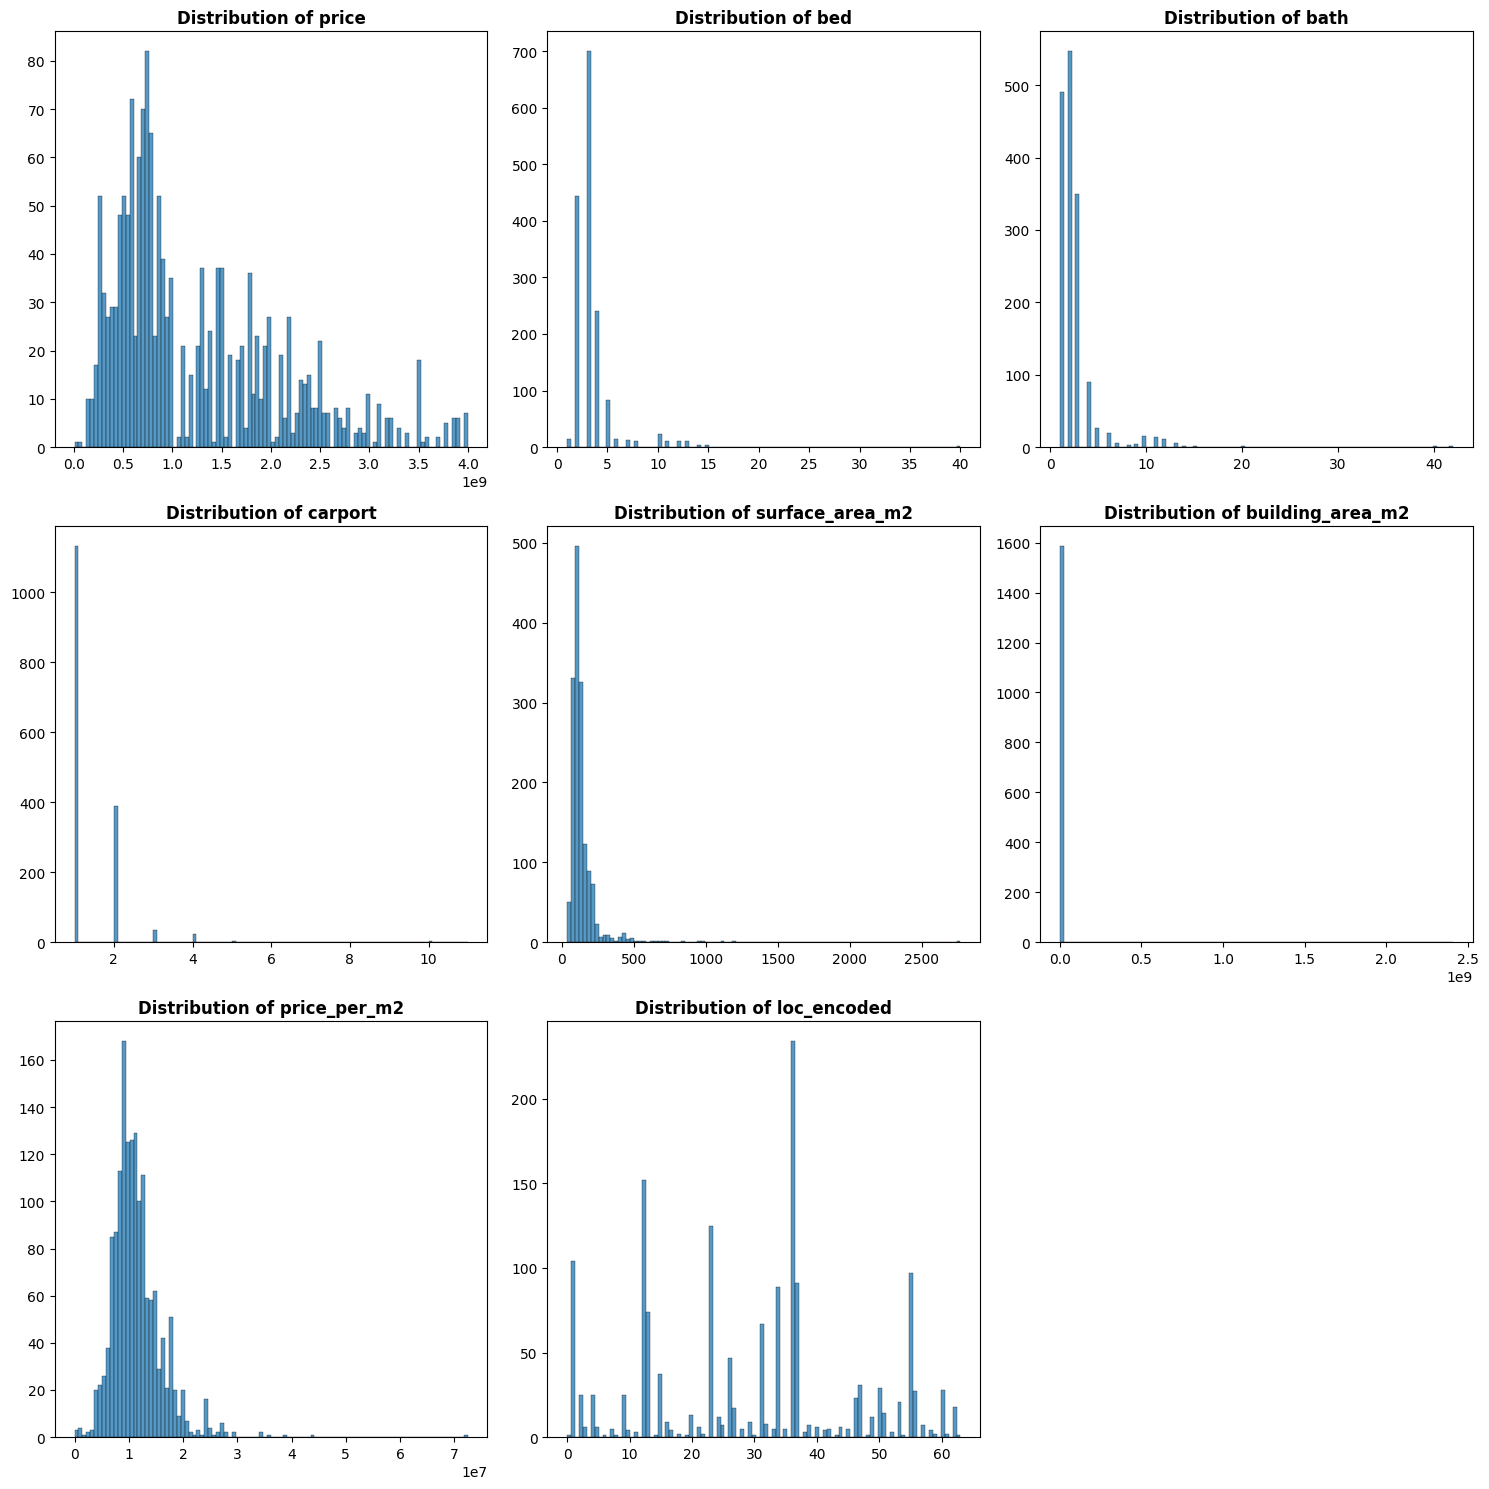

In [ ]:
#14 Distribusi setiap atribut (histogram)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(15, 8))
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5)) # Adjust figure size based on number of rows
for i, col in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(data=df, x=col, bins=100)
    plt.title(f'Distribution of {col}', fontweight='bold')
    plt.xlabel("")
    plt.ylabel("")

    if col == 'price':
        plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

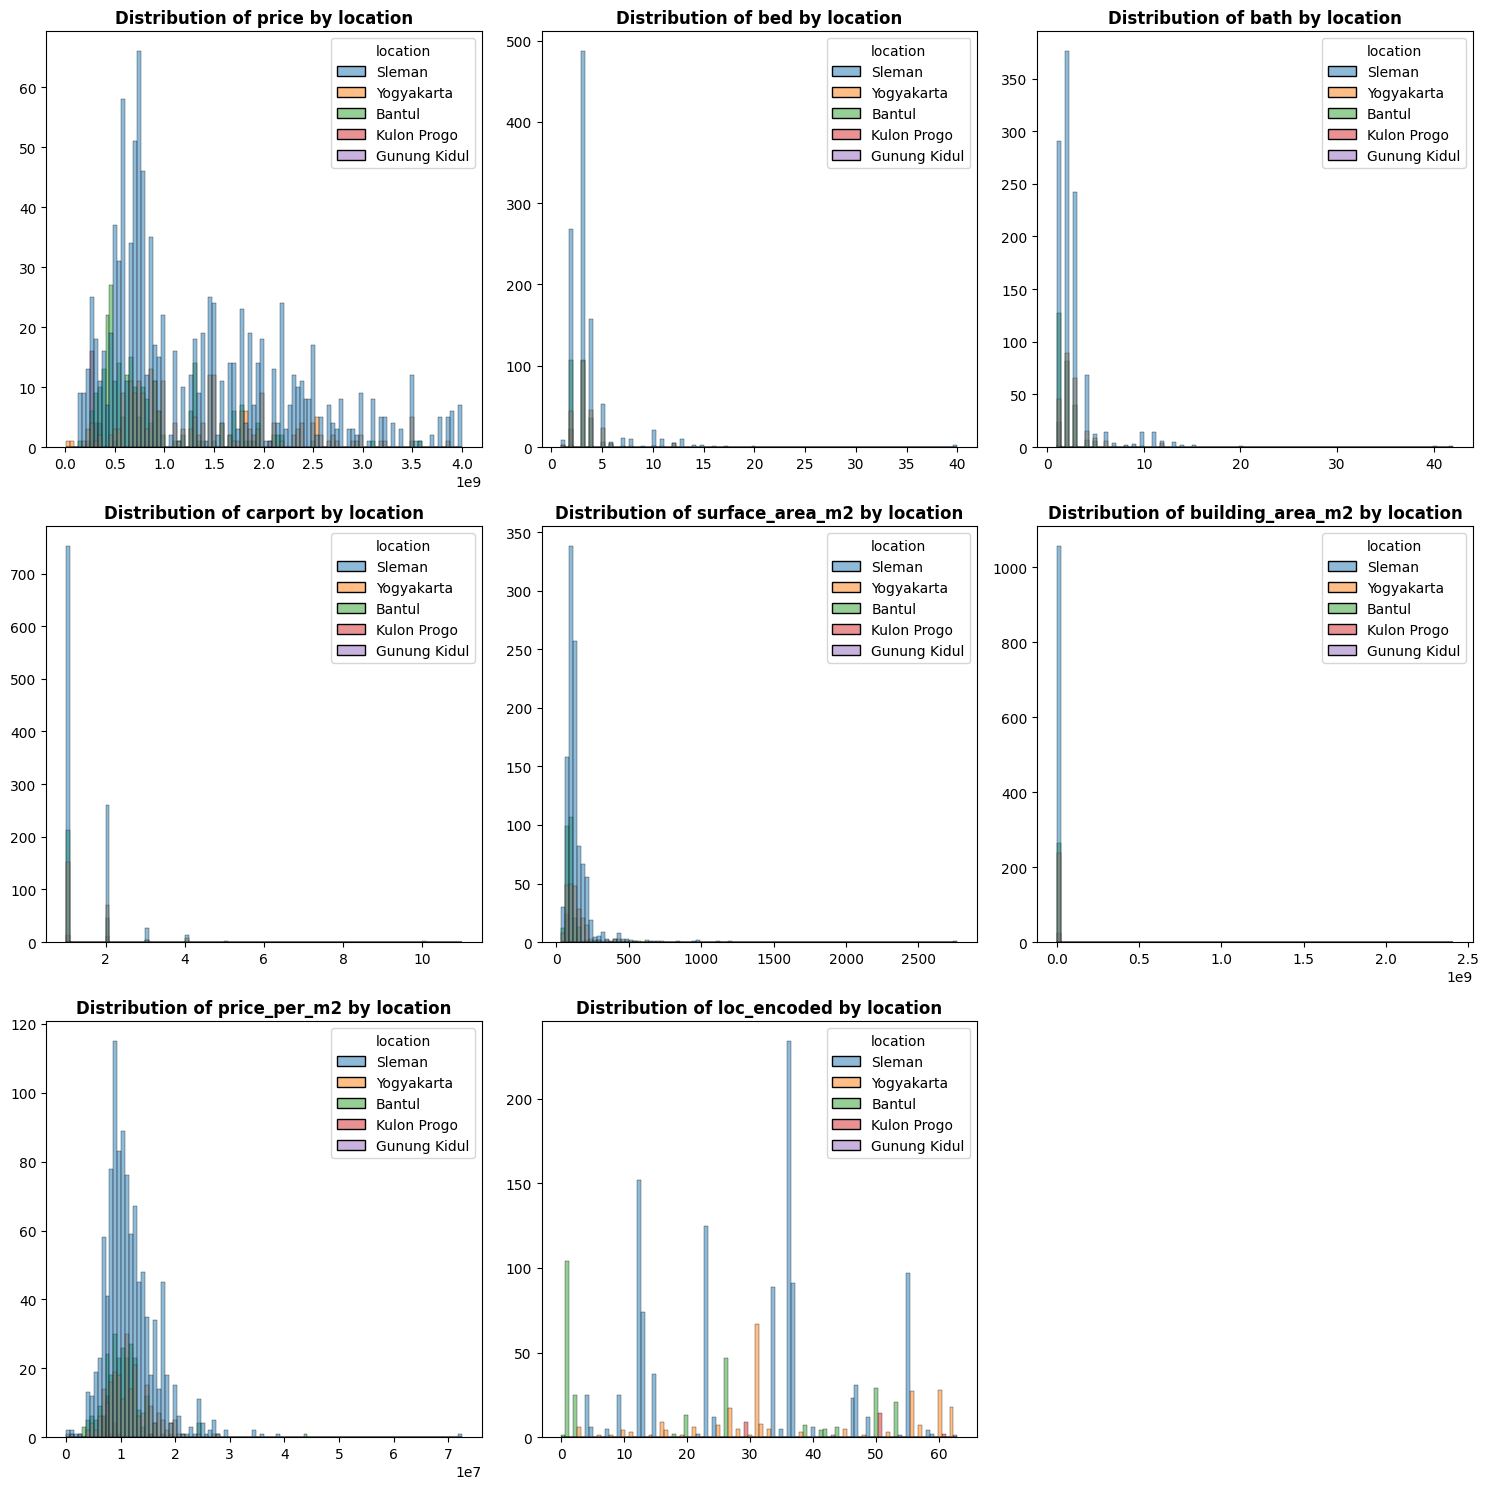

In [ ]:
#15 Distribusi setiap atribut berdasarkan lokasi (histogram dengan hue)
plt.figure(figsize=(15, 8))
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
n_cols = 3 # You can adjust the number of columns per row here
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5)) # Adjust figure size based on number of rows
for i, col in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(data=df, x=col, bins=100, hue='location')
    plt.title(f'Distribution of {col} by location', fontweight='bold')
    plt.xlabel("")
    plt.ylabel("")

    if col == 'price':
        plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()

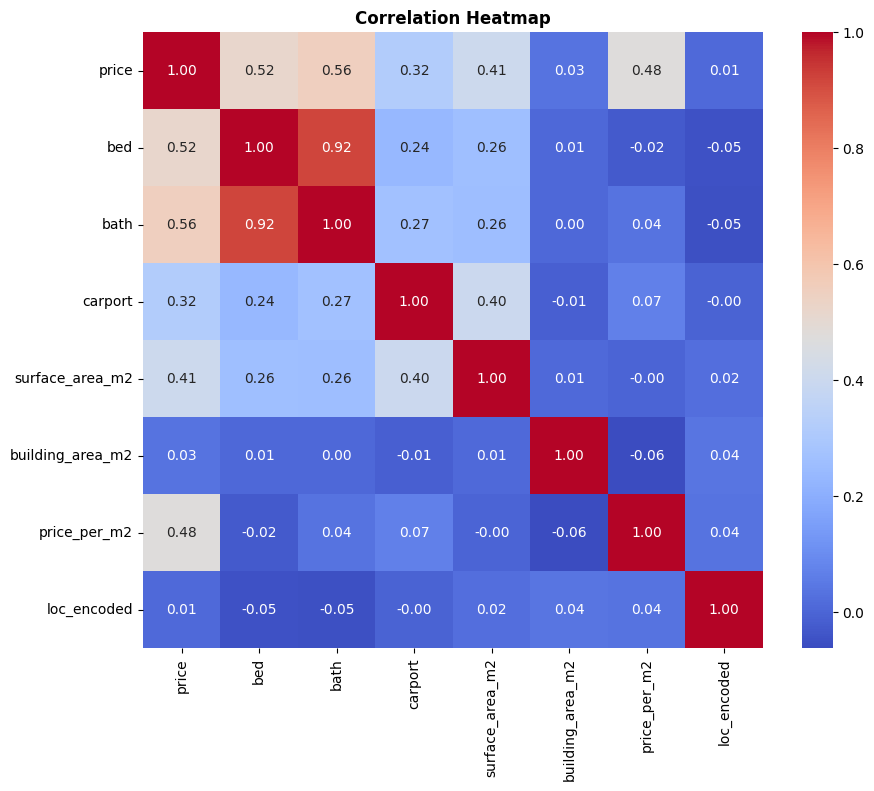

In [ ]:
#16 Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', fontweight='bold')
plt.show()

In [ ]:
#17 Feature correlation dengan target
print("\nKORELASI FITUR DENGAN HARGA (urut dari tertinggi):")
correlations = numeric_df.corr()['price'].abs().sort_values(ascending=False)
for feature, corr in correlations.items():
    if feature != 'price':
        print(f"- {feature}: {corr:.3f}")


KORELASI FITUR DENGAN HARGA (urut dari tertinggi):
- bath: 0.556
- bed: 0.519
- price_per_m2: 0.476
- surface_area_m2: 0.406
- carport: 0.318
- building_area_m2: 0.034
- loc_encoded: 0.010


In [ ]:
#18 Fungsi untuk remove outliers menggunakan IQR method
def remove_outliers_iqr(df, column):
    """
    Remove outliers menggunakan Interquartile Range (IQR) method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
    print(f"Outliers di kolom {column}: {outliers_count}")

    df_cleaned = df[~((df[column] < lower_bound) | (df[column] > upper_bound))]
    return df_cleaned

# Apply outlier removal pada kolom yang sensitive
print(f"Dataset sebelum remove outliers: {len(df)} baris")

# Remove outliers dari building_area_m2
df = remove_outliers_iqr(df, 'building_area_m2')

# Remove outliers dari surface_area_m2
df = remove_outliers_iqr(df, 'surface_area_m2')

# Remove outliers dari price (extreme values)
df = remove_outliers_iqr(df, 'price')

print(f"Dataset setelah remove outliers: {len(df)} baris")

Dataset sebelum remove outliers: 1587 baris
Outliers di kolom building_area_m2: 75
Outliers di kolom surface_area_m2: 60
Outliers di kolom price: 34
Dataset setelah remove outliers: 1418 baris


<Figure size 1500x1000 with 0 Axes>

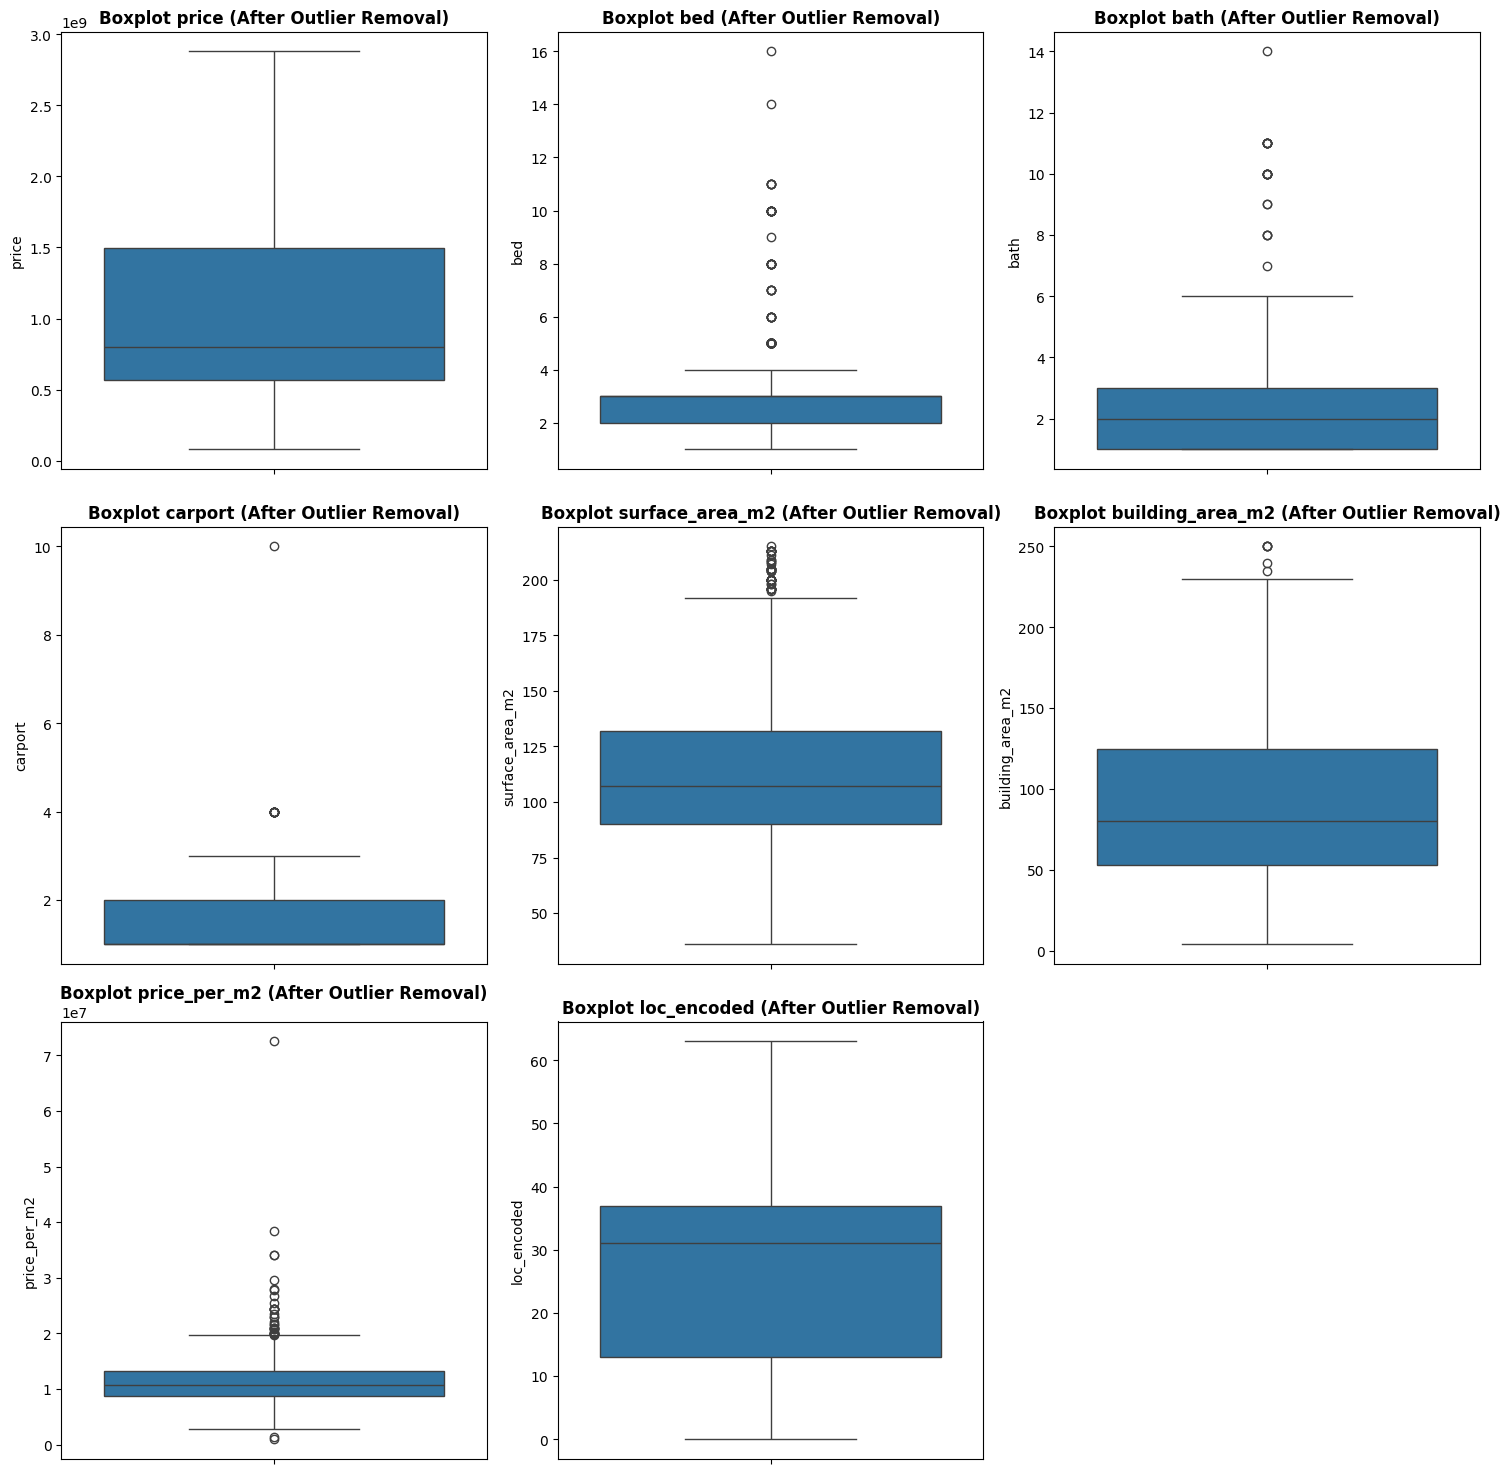

In [ ]:
#19 Visualisasi setelah outlier removal
plt.figure(figsize=(15, 10))
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5)) # Adjust figure size based on number of rows

for i, col in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot {col} (After Outlier Removal)', fontweight='bold')

    if col == 'price':
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

In [ ]:
#20 Encode categorical variables
print("Encoding categorical variables...")
le = LabelEncoder()
df['location_encoded'] = le.fit_transform(df['location'])

# Save label encoder untuk nanti digunakan saat prediksi
print("Location mapping:")
location_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for location, code in location_mapping.items():
    print(f"  {location}: {code}")

Encoding categorical variables...
Location mapping:
  Bantul: 0
  Gunung Kidul: 1
  Kulon Progo: 2
  Sleman: 3
  Yogyakarta: 4


In [ ]:
#21 Feature selection
# Pilih features untuk modeling
feature_columns = ['bed', 'bath', 'carport', 'building_area_m2', 'surface_area_m2', 'location_encoded']
target_column = 'price'

X = df[feature_columns]
y = df[target_column]

print(f"\nFeatures yang digunakan: {feature_columns}")
print(f"Target variable: {target_column}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


Features yang digunakan: ['bed', 'bath', 'carport', 'building_area_m2', 'surface_area_m2', 'location_encoded']
Target variable: price
X shape: (1418, 6)
y shape: (1418,)


In [ ]:
 #22 Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=None  # Tidak bisa stratify untuk regression
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Training ratio: {X_train.shape[0]/len(X)*100:.1f}%")
print(f"Testing ratio: {X_test.shape[0]/len(X)*100:.1f}%")

Training set: 1134 samples
Testing set: 284 samples
Training ratio: 80.0%
Testing ratio: 20.0%


In [ ]:
#23 Feature Scaling (opsional untuk Random Forest, tapi baik untuk konsistensi)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed!")

✅ Feature scaling completed!


In [ ]:
 #24 Baseline Random Forest model
print("Training baseline Random Forest model...")
rf_baseline = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

# Evaluasi baseline
y_pred_baseline = rf_baseline.predict(X_test)
baseline_r2 = r2_score(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)

print(f"Baseline Random Forest Performance:")
print(f"  R² Score: {baseline_r2:.4f}")
print(f"  RMSE: {baseline_rmse:,.0f}")
print(f"  MAE: {baseline_mae:,.0f}")

Training baseline Random Forest model...
Baseline Random Forest Performance:
  R² Score: 0.8486
  RMSE: 256,310,984
  MAE: 134,998,494


In [ ]:
#25 Hyperparameter tuning menggunakan RandomizedSearchCV
print("\nMelakukan hyperparameter tuning...")

# Define parameter distribution untuk RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# RandomizedSearchCV untuk efficiency
rf_random = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=param_distributions,
    n_iter=100,  # Jumlah kombinasi parameter yang akan dicoba
    cv=5,        # 5-fold cross validation
    random_state=42,
    n_jobs=-1,
    verbose=1,   # Print progress
    scoring='r2'
)

# Fit hyperparameter tuning
print("Proses hyperparameter tuning dimulai...")
print("Ini akan memakan waktu beberapa menit...")
random_search.fit(X_train, y_train)


Melakukan hyperparameter tuning...
Proses hyperparameter tuning dimulai...
Ini akan memakan waktu beberapa menit...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
195 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/util

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='r2', verbose=1)

In [ ]:
 #26 Best parameters dan best model
print("\n✅ Hyperparameter tuning selesai!")
print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best cross-validation R² score: {random_search.best_score_:.4f}")

# Get best model
best_rf_model = random_search.best_estimator_


✅ Hyperparameter tuning selesai!

Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best cross-validation R² score: 0.8452


In [ ]:
#27 Prediksi dengan best model
y_pred_tuned = best_rf_model.predict(X_test)

# Calculate metrics
tuned_r2 = r2_score(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)

# Cross-validation score
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='r2')

print("PERFORMA MODEL SETELAH HYPERPARAMETER TUNING:")
print(f"  R² Score: {tuned_r2:.4f}")
print(f"  RMSE: {tuned_rmse:,.0f}")
print(f"  MAE: {tuned_mae:,.0f}")
print(f"  Cross-validation R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

PERFORMA MODEL SETELAH HYPERPARAMETER TUNING:
  R² Score: 0.8677
  RMSE: 239,628,448
  MAE: 129,836,863
  Cross-validation R² (mean ± std): 0.8452 ± 0.0241


In [ ]:
#28 Perbandingan baseline vs tuned
print(f"\nPERBANDINGAN BASELINE VS TUNED:")
print(f"  R² Score - Baseline: {baseline_r2:.4f} | Tuned: {tuned_r2:.4f} | Improvement: {tuned_r2-baseline_r2:.4f}")
print(f"  RMSE - Baseline: {baseline_rmse:,.0f} | Tuned: {tuned_rmse:,.0f} | Improvement: {baseline_rmse-tuned_rmse:,.0f}")
print(f"  MAE - Baseline: {baseline_mae:,.0f} | Tuned: {tuned_mae:,.0f} | Improvement: {baseline_mae-tuned_mae:,.0f}")


PERBANDINGAN BASELINE VS TUNED:
  R² Score - Baseline: 0.8486 | Tuned: 0.8677 | Improvement: 0.0191
  RMSE - Baseline: 256,310,984 | Tuned: 239,628,448 | Improvement: 16,682,536
  MAE - Baseline: 134,998,494 | Tuned: 129,836,863 | Improvement: 5,161,632


In [ ]:
#29 Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFEATURE IMPORTANCE:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")


FEATURE IMPORTANCE:
  building_area_m2: 0.3833
  bath: 0.2369
  surface_area_m2: 0.2326
  bed: 0.1001
  carport: 0.0256
  location_encoded: 0.0214


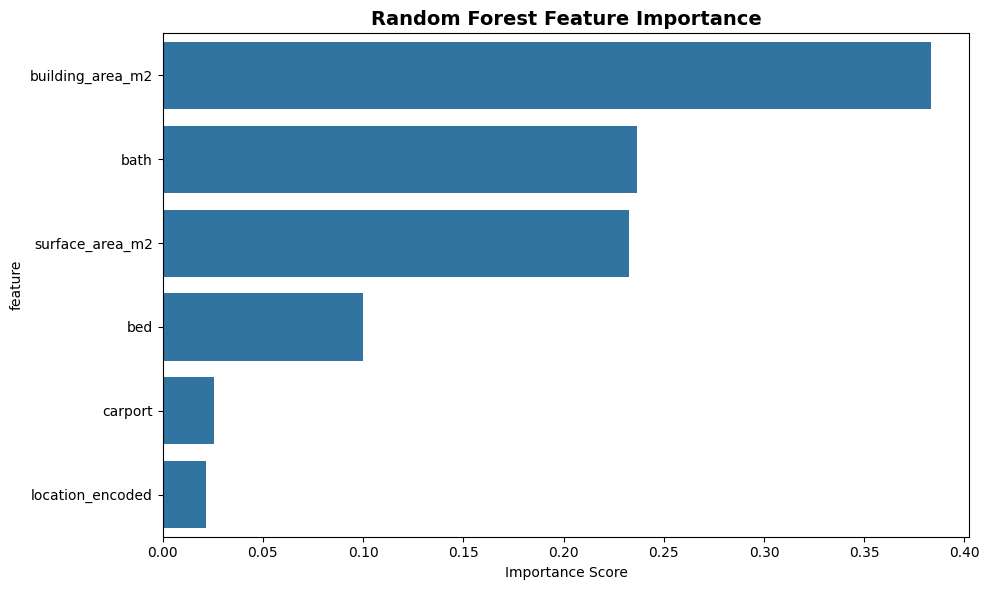

In [ ]:
#30 Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, y='feature', x='importance')
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

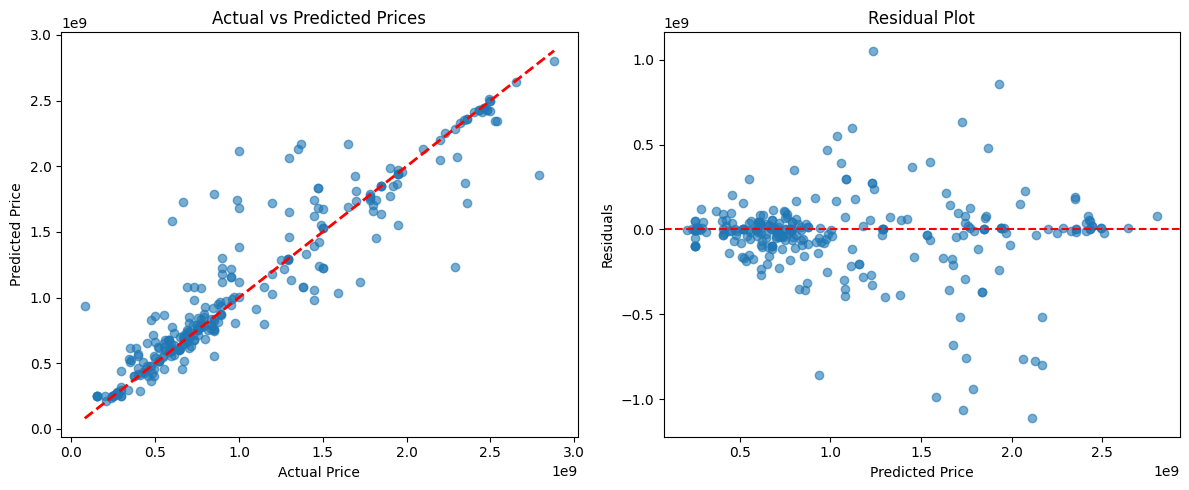

In [ ]:
#31 Actual vs Predicted plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_tuned
plt.scatter(y_pred_tuned, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()

In [ ]:
#32 Save model, scaler, dan label encoder
model_filename = 'yogyakarta_housing_price_rf_model.pkl'
scaler_filename = 'feature_scaler.pkl'
encoder_filename = 'location_encoder.pkl'

# Save best model
joblib.dump(best_rf_model, model_filename)
print(f"✅ Model saved as: {model_filename}")

# Save scaler
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved as: {scaler_filename}")

# Save label encoder
joblib.dump(le, encoder_filename)
print(f"✅ Label encoder saved as: {encoder_filename}")

# Save feature columns dan mapping information
model_info = {
    'feature_columns': feature_columns,
    'location_mapping': location_mapping,
    'model_performance': {
        'r2_score': tuned_r2,
        'rmse': tuned_rmse,
        'mae': tuned_mae,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    },
    'best_params': random_search.best_params_
}

joblib.dump(model_info, 'model_info.pkl')
print(f"✅ Model info saved as: model_info.pkl")

✅ Model saved as: yogyakarta_housing_price_rf_model.pkl
✅ Scaler saved as: feature_scaler.pkl
✅ Label encoder saved as: location_encoder.pkl
✅ Model info saved as: model_info.pkl


In [ ]:
 #33 Contoh data untuk prediksi
sample_data = {
    'bed': 3,
    'bath': 2,
    'carport': 1,
    'building_area_m2': 80.0,
    'surface_area_m2': 120.0,
    'location': 'Sleman'  # Akan di-encode
}

print("Sample data untuk prediksi:")
for key, value in sample_data.items():
    print(f"  {key}: {value}")

# Encode location
sample_data['location_encoded'] = le.transform([sample_data['location']])[0]
sample_data.pop('location')  # Remove original location

# Convert to DataFrame
sample_df = pd.DataFrame([sample_data])
sample_df = sample_df[feature_columns]  # Ensure correct column order

# Make prediction
predicted_price = best_rf_model.predict(sample_df)[0]

print(f"\n🏠 PREDIKSI HARGA: Rp {predicted_price:,.0f}")

# Confidence interval estimation (menggunakan MAE sebagai estimasi)
confidence_margin = tuned_mae
lower_bound = predicted_price - confidence_margin
upper_bound = predicted_price + confidence_margin

print(f"📊 Estimasi range harga: Rp {lower_bound:,.0f} - Rp {upper_bound:,.0f}")
print(f"📈 Model confidence (R² score): {tuned_r2:.1%}")

print("\n" + "="*60)
print("🎉 ANALISIS SELESAI!")
print("Model Random Forest berhasil dibangun dan siap digunakan untuk prediksi harga rumah di Yogyakarta")
print("="*60)

Sample data untuk prediksi:
  bed: 3
  bath: 2
  carport: 1
  building_area_m2: 80.0
  surface_area_m2: 120.0
  location: Sleman

🏠 PREDIKSI HARGA: Rp 805,630,302
📊 Estimasi range harga: Rp 675,793,440 - Rp 935,467,165
📈 Model confidence (R² score): 86.8%

🎉 ANALISIS SELESAI!
Model Random Forest berhasil dibangun dan siap digunakan untuk prediksi harga rumah di Yogyakarta
